In [1]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


In [2]:
import os
import re
import string
from pathlib import Path
from shutil import copyfileobj
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import json
from random import shuffle
import tiktoken

import zipfile

print(f"TF version: {tf.__version__}")

TF version: 2.14.0


In [3]:
# def archive(dir: Path):
#     with zipfile.ZipFile(f"{dir}.zip", "w", zipfile.ZIP_STORED) as zip_file:
#         for entry in dir.rglob("*"):
#             zip_file.write(entry, entry.relative_to(dir))
#
#
# def unarchive(file: Path):
#     with zipfile.ZipFile(file, "r") as zip_file:
#         zip_file.extractall(file.with_suffix(""))

In [4]:
def download_file(url, dataset_file_path):
    path = Path(dataset_file_path)
    os.makedirs(path.parent, exist_ok=True)
    if not path.exists():
        print(f"Downloading {path}")
        with urlopen(url) as fsrc, open(path, "wb") as fdst:
            copyfileobj(fsrc, fdst)
    else:
        print(f"File {path} exists")

In [5]:
dataset_path = "tmp/text_generation.json"
batch_size = 1024
seed = 123
max_seq_length = 100

In [6]:
download_file("https://huggingface.co/datasets/sahil2801/CodeAlpaca-20k/raw/main/code_alpaca_20k.json", dataset_path)

In [7]:
json_dataset = None
with open(dataset_path) as f:
    # noinspection PyRedeclaration
    json_dataset = json.load(f)

In [8]:
json_dataset[0]

{'instruction': 'Create an array of length 5 which contains all even numbers between 1 and 10.',
 'input': '',
 'output': 'arr = [2, 4, 6, 8, 10]'}

In [9]:
dataset = [f"instruction: {item['instruction']}\ninput: {item['input']}\noutput: {item['output']}"
           for item in json_dataset]
shuffle(dataset)

In [10]:
tokenizer = tiktoken.get_encoding("cl100k_base")
sequences = [tokenizer.encode(s) for s in dataset]
max(len(s) for s in sequences)

1145

In [11]:
def make_samples(lst, max_seq_length):
    seq = lst[:max_seq_length + 1]
    if len(lst) >= 2:
        samples = []
        for i in range(len(seq) - 1):
            sequence = seq[:i + 2]
            prefix = sequence[:-1] + ([0] * (max_seq_length + 1 - len(sequence)))
            completion = sequence[-1]
            samples.append((prefix, completion))
        return samples
    else:
        return []

In [12]:
samples = []
for i in range(len(sequences)):
    samples.extend(make_samples(sequences[i], max_seq_length))
    if i % 1000 == 0:
        print(f"seq {i} out of {len(sequences)}")

seq 0 out of 20022
seq 1000 out of 20022
seq 2000 out of 20022
seq 3000 out of 20022
seq 4000 out of 20022
seq 5000 out of 20022
seq 6000 out of 20022
seq 7000 out of 20022
seq 8000 out of 20022
seq 9000 out of 20022
seq 10000 out of 20022
seq 11000 out of 20022
seq 12000 out of 20022
seq 13000 out of 20022
seq 14000 out of 20022
seq 15000 out of 20022
seq 16000 out of 20022
seq 17000 out of 20022
seq 18000 out of 20022
seq 19000 out of 20022
seq 20000 out of 20022


In [13]:
# Plus OOV token and 0 index representing a mask
input_dim = tokenizer.n_vocab + 2

In [14]:
tokenizer.n_vocab

100277

In [15]:
split_size = 0.9
train_dataset = samples[:int(len(samples) * split_size)]
validation_dataset = samples[len(train_dataset):]
print(len(train_dataset), len(validation_dataset))

1256046 139561


In [16]:
train_prefixes = [prefix for prefix, completion in train_dataset]
train_completions = [completion for prefix, completion in train_dataset]
validation_prefixes = [prefix for prefix, completion in validation_dataset]
validation_completions = [completion for prefix, completion in validation_dataset]

In [17]:
train_prefixes = np.array(train_prefixes)
train_completions = np.array(train_completions)
validation_prefixes = np.array(validation_prefixes)
validation_completions = np.array(validation_completions)

In [18]:
model = tf.keras.Sequential([
    # text_vectorization_layer,

    layers.Embedding(input_dim, 64, mask_zero=True, input_length=max_seq_length),
    layers.LSTM(256, return_sequences=True),
    layers.LSTM(128),
    # tf.keras.layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(tokenizer.n_vocab, activation="softmax", name=f"output")
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           6417856   
                                                                 
 lstm (LSTM)                 (None, 100, 256)          328704    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 output (Dense)              (None, 100277)            6518005   
                                                                 
Total params: 13469941 (51.38 MB)
Trainable params: 13469941 (51.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["acc"]
)

In [21]:
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=f"tmp/checkpoints",
#     save_weights_only=False,
#     monitor=f"val_acc",
#     mode="max",
#     save_best_only=True,
# )
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=f"val_acc",
    mode="max",
)

In [23]:
epochs = 1
history = model.fit(
    x=train_prefixes,
    y=train_completions,
    batch_size=batch_size,
    epochs=epochs,
    steps_per_epoch=250,
    callbacks=[reduce_lr_callback],
    validation_data=(validation_prefixes, validation_completions),
    validation_steps=20,
)

250/250 [==============================] - 117s 468ms/step - loss: 6.4039 - acc: 0.0659 - val_loss: 6.1589 - val_acc: 0.0797 - lr: 0.0010


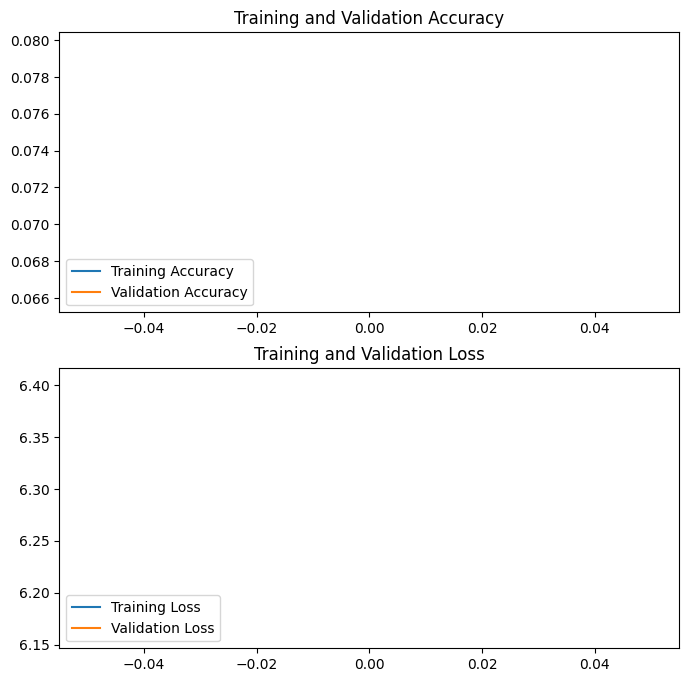

In [24]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower left")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="lower left")
plt.title("Training and Validation Loss")
plt.show()

In [25]:
def pad(tokens, max_seq_length):
  assert len(tokens) <= max_seq_length
  return tokens + ([0] * (max_seq_length - len(tokens)))

In [26]:
tokenizer.decode(train_prefixes[100])

'instruction: Write a function to compare two strings. The function should return true if the strings are equal and false if the strings are not equal.\ninput: string_1 =!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'

In [27]:
# input = "instruction: Design an algorithm to print out the prime numbers between 1 and 100.\ninput: \noutput: "
input = "instruction: Create a JavaScript to switch between two div components.\ninput: \noutput: "

(18, 100)

In [28]:
def generate_completion(input):
  input_tokens = tokenizer.encode(input)
  input_padded = pad(input_tokens, max_seq_length)
  print(tokenizer.decode(input_padded))
  completion = input_padded.copy()
  for i in range(max_seq_length - len(input_tokens)):
  # for i in range(100):
    output = model(tf.expand_dims(completion, 0))[0]
    # token = tf.argmax(output)
    top_k = tf.math.top_k(output, k=3)
    # print(f"top_k: {top_k}")
    # print(f"top_k tokens: {tokenizer.decode(top_k.indices)}")
    # p_sum = sum(top_k.values)
    # p = top_k.values.numpy().astype(np.float32) / p_sum
    token = np.random.choice(top_k.indices)
    # print(f"token: {token} '{tokenizer.decode([token])}'")
    completion[i + len(input_tokens)] = token
  return tokenizer.decode(completion)

instruction: Create a JavaScript to switch between two div components.
input: 
output: !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Completion:
instruction: Create a JavaScript to switch between two div components.
input: 
output:  
,  = =,,,  ,     ,           ,,       ,      ,   ,          ,      ,  ,,                    ,,, ,       ,,      ,    ,,   ,   ,      , 


In [ ]:
generate_completion(input)

In [29]:
model.save("tmp/model.h5", save_format="h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
